# Trabajo Práctico 2: Análisis con K-Nearest Neighbors (KNN) - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test), y test holdout.

In [6]:
X, y = dividir_dataset(df)
X_train_test_original, X_holdout_original, y_train_test, y_holdout = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
X_train_test, X_holdout = normalizar_datos(X_train_test_original, X_holdout_original)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros mediante la siguiente función de búsqueda. Estos son la distancia, la métrica utilizada y K, que determina la cantidad de vecinos a tener en cuenta. Nos quedamos con la combinación que maximice la métrica de comparación utilizada, que es AUC-ROC.

In [7]:
def definir_mejores_hiperparametros(X, y, modelo):   
    params = {'weights': ['uniform', 'distance'], 'n_neighbors':[2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70],'metric': ['minkowski','cosine','chebyshev','correlation']}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)    
    return grid_search.best_params_ 

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X_train_test, y_train_test, KNeighborsClassifier())

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [9]:
mejor_k = mejor_combinacion['n_neighbors']
mejor_distancia = mejor_combinacion['weights']
mejor_metrica = mejor_combinacion['metric']
print(f'Mejor cantidad de vecinos (k): {mejor_k}')
print(f'Mejor distancia: {mejor_distancia}')
print(f'Mejor métrica: {mejor_metrica}')

Mejor cantidad de vecinos (k): 30
Mejor distancia: uniform
Mejor métrica: cosine


Entrenamos KNN con esa mejor combinación:

In [10]:
knn = KNeighborsClassifier(n_neighbors = mejor_k, weights = mejor_distancia, metric = mejor_metrica)
knn.fit(X_train_test, y_train_test)

KNeighborsClassifier(metric='cosine', n_neighbors=30)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

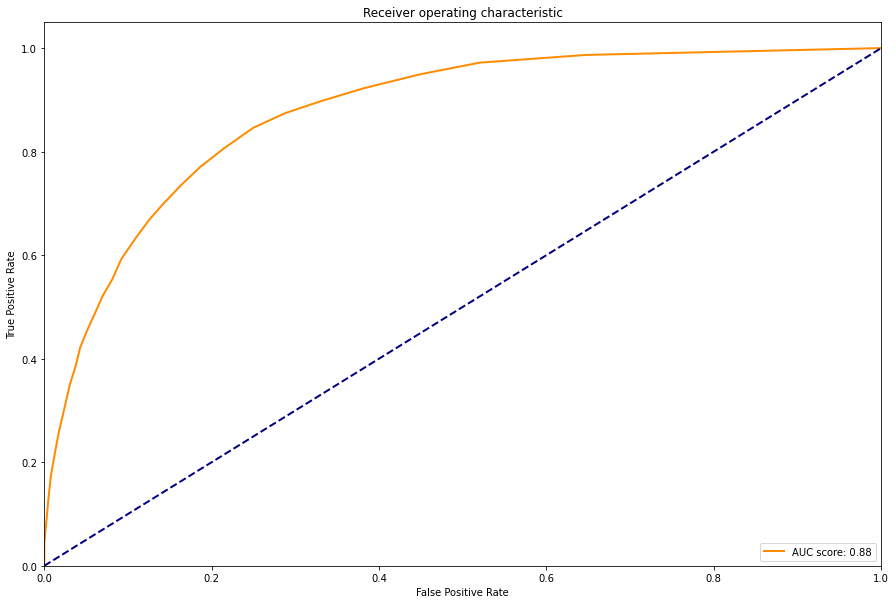

El valor de la metrica AUC-ROC para este modelo es: 0.8763273890692015


In [11]:
y_pred = knn.predict(X_holdout)
y_pred_proba = knn.predict_proba(X_holdout)[:,1]
graficar_auc_roc(y_holdout, y_pred_proba)

Podemos observar que el AUC score es muy alto (0.88), lo cual quiere decir que estamos frente a un buen clasificador. 

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [12]:
print(classification_report(y_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.860     0.930     0.894      6181
   Tiene Alto Valor Adquisitivo      0.703     0.521     0.599      1960

                       accuracy                          0.832      8141
                      macro avg      0.781     0.726     0.746      8141
                   weighted avg      0.822     0.832     0.823      8141



Por último, mostramos la matriz de confusión correspondiente:

In [13]:
from funciones_auxiliares import graficar_matriz_confusion

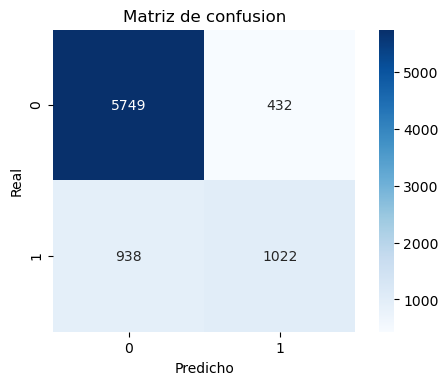

In [14]:
graficar_matriz_confusion(y_holdout, y_pred)

Podemos ver que el modelo clasifica muy bien las instancias con bajo valor adquisitivo, proporcionando un alto recall y precision para estas. Sin embargo, el recall para las instancias con altos ingresos no es muy alto (0.521), y, como se puede ver, predice mal muchas de estas instancias (938 instancias).

Se podría decir que existe una notoria tendencia del modelo a predecir clases como bajo valor adquisitivo, ya que predijo casi la mitad de las instancias de altos ingresos como instancias de bajos ingresos.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train_test_original, X_exp_holdout_original, y_exp_train_test, y_exp_holdout = train_test_split(X_exp, y, test_size=0.25, random_state=0, stratify=y)
X_exp_train_test, X_exp_holdout = normalizar_datos(X_exp_train_test_original, X_exp_holdout_original)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [17]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp_train_test, y_exp_train_test, KNeighborsClassifier())

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [18]:
mejor_k = mejor_combinacion['n_neighbors']
mejor_distancia = mejor_combinacion['weights']
mejor_metrica = mejor_combinacion['metric']
print(f'Mejor cantidad de vecinos (k): {mejor_k}')
print(f'Mejor distancia: {mejor_distancia}')
print(f'Mejor métrica: {mejor_metrica}')

Mejor cantidad de vecinos (k): 40
Mejor distancia: uniform
Mejor métrica: cosine


Entrenamos KNN con esa mejor combinación:

In [19]:
knn_expandido = KNeighborsClassifier(n_neighbors = mejor_k, weights = mejor_distancia, metric = mejor_metrica)
knn_expandido.fit(X_exp_train_test, y_exp_train_test)

KNeighborsClassifier(metric='cosine', n_neighbors=40)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

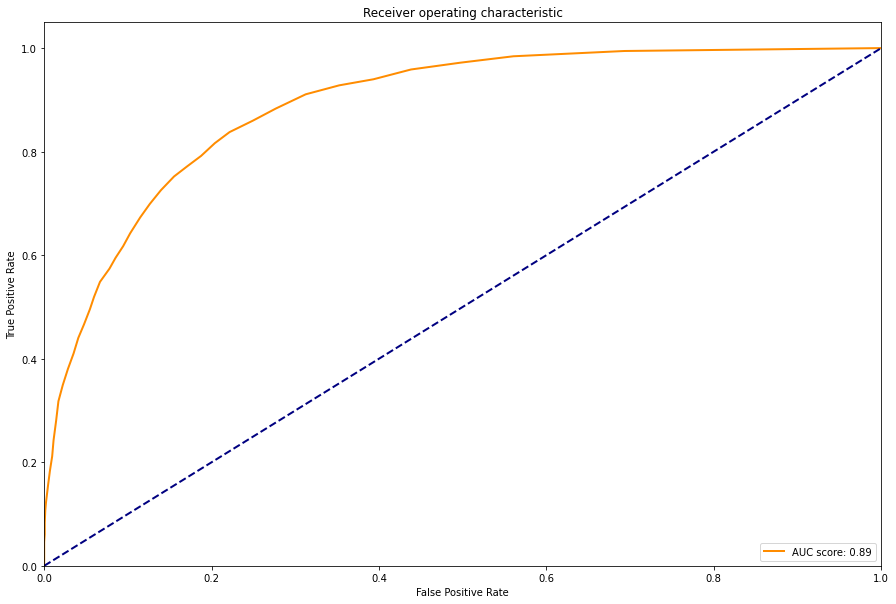

El valor de la metrica AUC-ROC para este modelo es: 0.8893455173688956


In [20]:
y_pred = knn_expandido.predict(X_exp_holdout)
y_pred_proba = knn_expandido.predict_proba(X_exp_holdout)[:, 1]
graficar_auc_roc(y_exp_holdout, y_pred_proba)

Podemos ver que el resultado es un poco superior al del que se obtuvo con el dataset original.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc. Allí vemos que hay un aumento en el f1-score para las instancias con alto valor adquisitivo respecto a la predicción con el dataset original, debido a un aumento en el recall.

In [21]:
print(classification_report(y_exp_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.872     0.922     0.896      6181
   Tiene Alto Valor Adquisitivo      0.700     0.574     0.631      1960

                       accuracy                          0.838      8141
                      macro avg      0.786     0.748     0.764      8141
                   weighted avg      0.831     0.838     0.832      8141



Por último, mostramos la matriz de confusión correspondiente:

In [22]:
from funciones_auxiliares import graficar_matriz_confusion

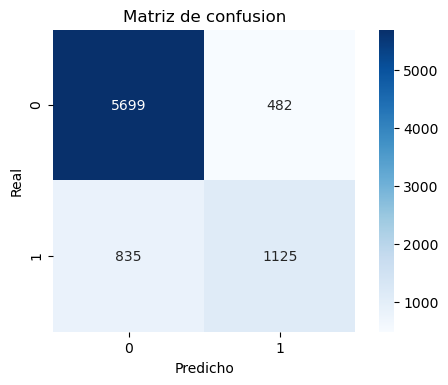

In [23]:
graficar_matriz_confusion(y_exp_holdout, y_pred)

Podemos ver que con el dataset ampliado, se obtuvo un resultado similar, aunque mejoró un poco la predicción de las instancias con alto valor adquisitivo, es decir, el recall.

También disminuye la tendencia a predecir ceros por sobre unos, en comparación al dataset original, pero aún sigue presente.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con KNN sobre el dataset de predicciones expandido, ya que es el que nos dio un score más alto en la métrica AUC-ROC, y la escribimos al archivo 'KNN.csv'.

In [24]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [25]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)
X_exp_train_test_normalizado, df_predicciones = normalizar_datos(X_exp_train_test_original, df_predicciones)

In [26]:
predicciones = knn_expandido.predict(df_predicciones)
escribir_predicciones(ids, predicciones, "KNN")